要模拟一个情景，其中有600个人站成一排，每次随机杀掉一个奇数位置的人，目的是找出哪个位置的人最安全。具体实现可以分为以下几个步骤和解释：

### 1. 问题理解

- **初始状态**：有600个人站成一排，编号从1到600。
- **杀人规则**：每一轮中，随机选择当前存活的奇数编号的人，杀掉他们。
- **最终目标**：运行多次模拟，统计每个人被杀的轮次，找出哪些编号的人最晚被杀，或者可能存活到最后。

### 2. 实现思路

实现的关键在于通过多次模拟，记录每个编号的人在每次模拟中被杀的轮次，然后通过统计找到最安全的位置。

### 3. 关键步骤解释

1. **`random_kill(n)` 和 `random_kill_list(alive_ids)` 函数**：
   - `random_kill(n)`：在给定范围内随机选择一个奇数位置的人。
   - `random_kill_list(alive_ids)`：从当前存活的人中，选择一个奇数位置的人进行淘汰。

2. **`run_simulation_numpy(num_people)` 函数**：
   - `ids`：表示所有人的编号，从1到600。
   - `status`：表示每个人的生存状态，1表示存活，0表示被淘汰。
   - `killed_turn`：记录每个人被淘汰的回合，初始值为-1表示尚未被淘汰。
   - 每轮循环中，`alive_ids`会筛选出当前存活的编号，然后随机淘汰其中一个奇数编号的人。
   - 淘汰后更新 `status` 和 `killed_turn`，最后将结果存储在一个DataFrame中。

3. **多次模拟**：
   - 通过循环运行 `run_simulation_numpy(num_people)` N次（例如20000次），在每次模拟中记录每个人的淘汰回合。
   - 结果存储在 `df_simul` DataFrame中，每一列表示一次模拟的结果。



In [70]:
import pandas as pd
import numpy as np
import random
import warnings
import seaborn as sns
from pylab import mpl, plt

# best font and style settings for notebook
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = '微软雅黑'
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook


def random_kill(n):
    # 生成一个随机的奇数，范围从0到n-1
    return random.choice([i for i in range(n) if i % 2 == 0])


def random_kill_list(alive_ids):
    n = len(alive_ids)
    return alive_ids[random_kill(n)]


def run_simulation_numpy(num_people):

    # 初始化 NumPy 数组
    ids = np.arange(1, num_people + 1)
    status = np.ones(num_people, dtype=int)  # 1表示存活
    killed_turn = np.full(num_people, -1)  # 初始化淘汰回合

    for turn in range(num_people):
        alive_ids = ids[status == 1]  # 获取当前存活的ID
        if len(alive_ids) == 0:  # 如果没有存活者，提前退出循环
            break

        kill_id = random_kill_list(alive_ids) - 1  # 选择要淘汰的ID

        status[kill_id] = 0  # 标记为淘汰
        killed_turn[kill_id] = turn + 1  # 记录淘汰回合

    # 转换为 DataFrame
    df = pd.DataFrame({
        "id": ids,
        "status": status,
        "killed_turn": killed_turn
    })

    return df


def random_kill_optimized(alive_ids):
    # Vectorized way to choose a random alive person to kill
    return np.random.choice(alive_ids)


def run_simulation_optimized(num_people):
    # Initialize arrays
    ids = np.arange(1, num_people + 1)
    status = np.ones(num_people, dtype=int)  # 1表示存活
    killed_turn = np.full(num_people, -1)  # 初始化淘汰回合

    alive_ids = np.arange(num_people)

    for turn in range(num_people - 1):
        if len(alive_ids) == 0:  # 如果没有存活者，提前退出循环
            break

        kill_id = random_kill_optimized(alive_ids)  # Choose ID to kill
        status[kill_id] = 0  # Mark as killed
        killed_turn[kill_id] = turn + 1  # Record the turn when killed

        alive_ids = alive_ids[alive_ids
                              != kill_id]  # Remove killed ID from alive list

    # Convert to DataFrame
    df = pd.DataFrame({
        "id": ids,
        "status": status,
        "killed_turn": killed_turn
    })

    return df


#
num_people = 100
N = 10000
df_simul = pd.DataFrame({"id": range(1, 1 + num_people)})
for i in tqdm_notebook(range(N)):
    result_df = run_simulation_numpy(num_people)
    df_simul[f'turn_{i}'] = result_df['killed_turn']

result_df

  0%|          | 0/10000 [00:00<?, ?it/s]

,id,status,killed_turn
0,1,0,30
1,2,0,71
2,3,0,9
3,4,0,74
4,5,0,49
...,...,...,...
95,96,0,80
96,97,0,48
97,98,0,66
98,99,0,23


In [59]:
df_simul.iloc[df_simul.iloc[:,1:].idxmax()]

,id,turn_0,turn_1,turn_2,turn_3,turn_4,turn_5,turn_6,turn_7,turn_8,...,turn_9990,turn_9991,turn_9992,turn_9993,turn_9994,turn_9995,turn_9996,turn_9997,turn_9998,turn_9999
77,78,100,70,66,48,94,36,52,93,58,...,82,26,83,78,74,98,52,84,4,72
74,75,38,100,64,31,30,66,87,66,9,...,98,12,60,7,38,73,1,1,55,45
96,97,58,40,100,41,92,60,92,32,24,...,79,49,32,17,96,1,36,78,56,84
78,79,94,66,92,100,73,49,7,65,16,...,45,19,58,73,86,41,41,19,76,8
42,43,1,45,87,22,100,64,33,12,57,...,36,76,99,19,83,28,96,71,34,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,64,85,7,37,2,39,11,7,13,...,39,32,41,22,25,100,21,86,66,90
61,62,62,30,22,5,85,84,89,100,85,...,35,56,38,92,84,25,100,98,77,22
48,49,76,33,54,87,18,38,50,74,71,...,57,96,84,6,78,59,28,100,99,1
59,60,88,67,50,44,76,98,46,24,75,...,54,67,55,39,13,68,74,50,100,5


<AxesSubplot:xlabel='id'>

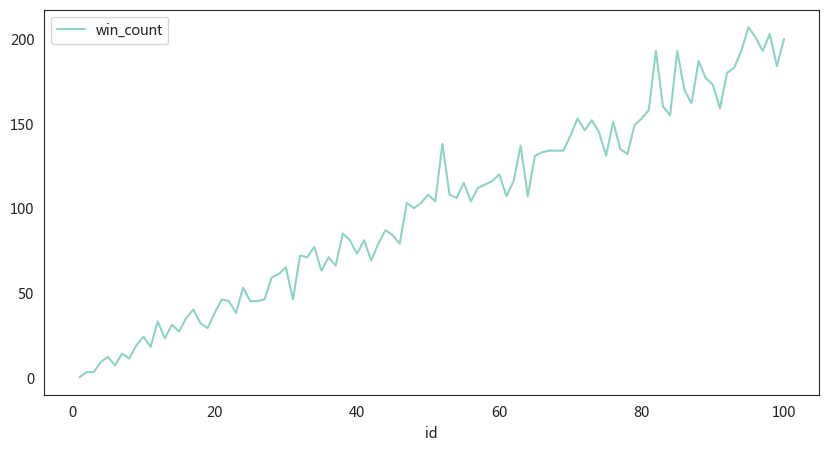

In [60]:
# 统计每个ID成为最后一个被淘汰的次数
last_killed = df_simul.iloc[:, 1:].idxmax()
last_killed_counts = {}
for i in range(1, len(df_simul) + 1):
    last_killed_counts[i] = 0
# print(last_killed_counts.keys())
for i in df_simul.loc[df_simul.iloc[:, 1:].idxmax()]['id']:
    last_killed_counts[i] += 1
last_killed_counts = pd.DataFrame({
    'id': last_killed_counts.keys(),
    'win_count': last_killed_counts.values()
})

last_killed_counts.plot(x='id', y='win_count', figsize=(10, 5))

In [61]:
last_killed_counts.sort_values('win_count',ascending=False)

,id,win_count
94,95,207
97,98,203
95,96,201
99,100,200
96,97,193
...,...,...
3,4,9
5,6,7
2,3,3
1,2,3


In [62]:
df_simul['average_alive_turns'] = df_simul.T.mean()
df_simul[['id', 'average_alive_turns']].sort_values(by='average_alive_turns',
                                                    ascending=False)

,id,average_alive_turns
1,2,56.265373
3,4,54.821618
5,6,54.246975
9,10,53.086491
7,8,52.889311
...,...,...
8,9,47.849215
6,7,46.754225
4,5,45.764524
2,3,42.856214


<AxesSubplot:xlabel='id'>

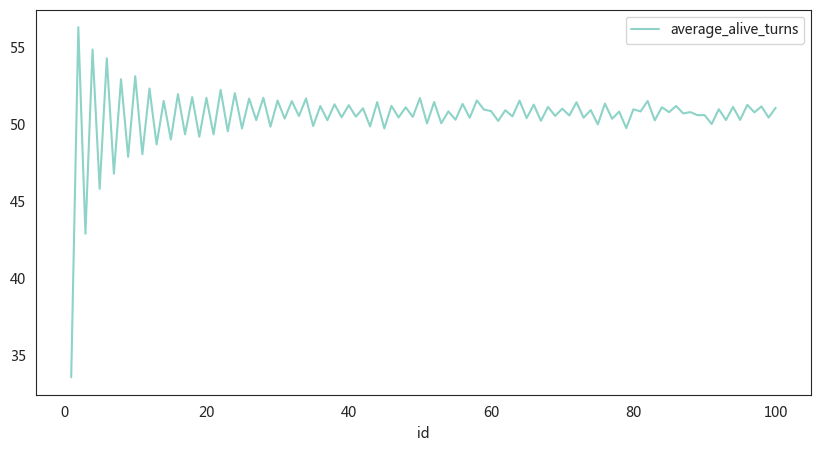

In [63]:
df_simul[['id', 'average_alive_turns']].plot(x='id',y='average_alive_turns',figsize=(10,5))

In [64]:
!jupyter nbconvert --to html random_kill_final.ipynb

[NbConvertApp] Converting notebook random_kill_final.ipynb to html
[NbConvertApp] Writing 383929 bytes to random_kill_final.html


In [65]:
!jupyter nbconvert --to markdown random_kill_final.ipynb

[NbConvertApp] Converting notebook random_kill_final.ipynb to markdown
[NbConvertApp] Support files will be in random_kill_final_files/
[NbConvertApp] Writing 13824 bytes to random_kill_final.md
